# A Kolmogorov-Arnold Network Application to the Predictive Maintenance Problem

Previously, we developed a [predictive maintenance model](predictive-maintenance) utilizing a Random Forest algorithm to classify engine conditions. In this experiment, we explore the application of a [Kolmogorov-Arnold Network](../thoughts/kolmogorov-arnold-networks) (KAN) to tackle the same classification task, aiming to evaluate its effectiveness and compare the results.


## Loading the dataset

We begin by following the initial steps of our previous experiment, starting with loading the dataset and ensuring it is ready for the Kolmogorov-Arnold Network application.

In [1]:
# Load engine data from dataset into a pandas dataframe

import pandas as pd

engine = pd.read_csv('.data/engine_data.csv')

In [2]:
# To avoid issues further down, let us rename the columns to remove spaces

engine.columns = engine.columns.str.replace(' ', '_')

In [3]:
# Split the data into features and target

X = engine.drop('Engine_Condition', axis=1)
y = engine['Engine_Condition']

y.value_counts()

Engine_Condition
1    12317
0     7218
Name: count, dtype: int64

Similar to our previous experiment, we utilize SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset, ensuring an equal representation of each class.

In [4]:
# There is a class imbalance in the target variable. We will use the SMOTE technique to balance the classes.

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_resampled, y_resampled = sm.fit_resample(X, y)

## Preparing the dataset for the Kolmogorov-Arnold Network

Let's now prepare things for the [PyTorch KAN implementation](https://github.com/KindXiaoming/pykan/tree/master), paying specific attention to stratified sampling so the model sees a balanced number of samples.

```{tip}
Notice the KAN implementation does not seem to work with MPS (Apple Silicon) devices, so we are setting all tensorts to run on the CPU.
```

In [5]:
import torch
from sklearn.model_selection import train_test_split

# Set default torch device to mps when available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu' # MPS doesn't seem to work with KAN
torch.set_default_device(device)
print('Using device:', torch.get_default_device())

# Remember column names for later plotting
column_names = X.columns.to_list()
labels = y.unique()


# Split the data into training and test sets, with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Put X_train, X_test, y_train, y_test into dataset['train_input'], dataset['test_input'], dataset['train_label'], dataset['test_label']
dataset = {}
dataset['train_input'] = torch.tensor(X_train.values, dtype=torch.float32)
dataset['test_input'] = torch.tensor(X_test.values, dtype=torch.float32)
dataset['train_label'] = torch.tensor(y_train.values , dtype=torch.int64)
dataset['test_label'] = torch.tensor(y_test.values, dtype=torch.int64)

X = dataset['train_input']
y = dataset['train_label']

samples = X.shape[0]

print(X.shape, y.shape)

Using device: cpu
torch.Size([19707, 6]) torch.Size([19707])


## Dataset complexity

## Dataset Complexity

When we [introduced the Kolmogorov-Arnold Network](../thoughts/kolmogorov-arnold-networks), we used a non-linearly separable toy dataset to illustrate the fundamental principles and capabilities of the model. The dataset employed in this experiment, however, is not only non-linearly separable but also significantly more complex. 

This complexity arises from several factors. Firstly, the dataset contains a higher number of features, each contributing to the predictive maintenance problem in different ways. The features include various engine parameters such as engine rpm, lubrication oil pressure, fuel pressure, coolant pressure, lubrication oil temperature, and coolant temperature. These parameters are inherently interrelated and their interactions are non-linear, which adds to the dataset's complexity.

Another layer of complexity comes from the real-world nature of the data. Unlike synthetic or toy datasets, real-world data often contains outliers, and other anomalies. Moreover, the target variable, which indicates whether an engine is in good condition or not, is influenced by multiple latent factors not directly captured in the dataset. This introduces hidden dependencies and non-linear relationships that the model needs to learn. 

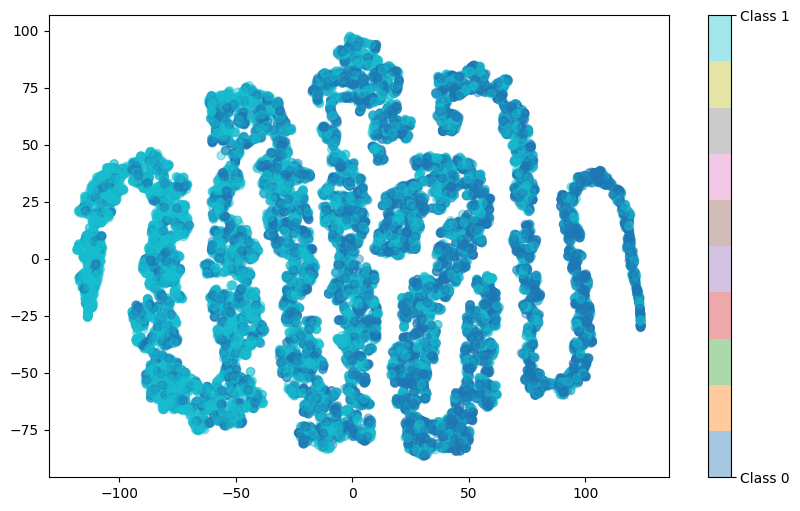

In [6]:
# Plot X/y as a 2D scatter plot, using tSNE to reduce the dimensionality
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np

# Applying tSNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X.cpu())

# Plotting
fig = plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y.cpu(), cmap='tab10', alpha=0.4)

# Customize the color bar
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['Class 0', 'Class 1'])

plt.show()

This plot illustrates the distribution of the two classes (Class 0 and Class 1), where Class 0 represents engines in good condition and Class 1 represents engines at fault. The complex and intertwined nature of the data points, as depicted in this t-SNE plot, highlights the significant challenge in class separation. The high degree of overlap and the non-linear separability of the classes make it evident that any model attempting to classify this dataset must effectively capture these intricate patterns and relationships.

Let us remind ourselves of the dataset's features and target variable.

In [7]:
print('Column names:', column_names)
print("Unique labels:", labels)

Column names: ['Engine_rpm', 'Lub_oil_pressure', 'Fuel_pressure', 'Coolant_pressure', 'lub_oil_temp', 'Coolant_temp']
Unique labels: [1 0]


## Creating the model

The general advice by the KAN authors is to first start with a small network, tune hyperparameters, and if nothing else works make the network wider (more neurons), and then deeper (more layers). We initiate with a straightforward shallow network comprising six input neurons and two output neurons. Our activation functions will employ fourth-degree B-Splines, and we will begin with a grid size of \$mathbf{10}$. B-Splines, or Basis Splines, are instrumental in computer graphics, data fitting, and numerical analysis, providing a balance between flexibility and computational efficiency.

```{index} B-Splines
```

```{note}
A B-Spline, or Basis Spline, is a type of spline used in computer graphics, data fitting, and numerical analysis, particularly within machine learning for tasks like regression and smoothing. It is a piecewise polynomial function, meaning it is composed of several polynomial segments joined together. These polynomials can be of any degree, but cubic B-Splines are most common because they offer a good balance between flexibility and computational efficiency.

One of the key characteristics of B-Splines is their smoothness. The polynomial segments are connected in a way that ensures the overall curve is smooth. The degree of smoothness depends on the degree of the polynomials and the continuity constraints applied at the segment boundaries, known as knots. The positions where these polynomial pieces meet are called knots, and the sequence of these knots is referred to as the knot vector. This vector determines where and how the pieces of the spline join.

B-Splines also exhibit local control properties. This means that adjusting a control point affects only a local part of the curve, making them ideal for fine-tuning specific areas without altering the entire curve. The 'B' in B-Spline stands for basis, indicating that a B-Spline is a linear combination of basis functions. These basis functions are defined recursively and determine the shape and smoothness of the spline.

In machine learning, B-Splines are used for various applications. They can fit smooth curves to data points in regression tasks, which is particularly useful for non-linear regression where a simple linear model isn't sufficient. They can also be used in feature engineering to transform features and capture non-linear relationships without explicitly defining the functional form. B-Splines are helpful in interpolation, providing smooth transitions between data points in time-series analysis and other tasks. Additionally, they are useful in dimensionality reduction and manifold learning for representing complex shapes and surfaces in high-dimensional spaces.

Mathematically, a B-Spline of degree $\mathbf{k}$ with a knot vector $\mathbf{t = [t_0, t_1, \ldots, t_n]}$ is defined as 

$$
S(t) = \sum_{i=0}^{n} c_i B_{i,k}(t) 
$$

where $\mathbf{c_i}$ are the control points, and $\mathbf{B_{i,k}(t)}$ are the basis functions of degree $\mathbf{k}$. These basis functions are defined recursively. For zero degree $\mathbf{k=0}$, 

$$
B_{i,0}(t) = \begin{cases} 
1 & \text{if } t_i \leq t < t_{i+1} \\
0 & \text{otherwise}
\end{cases} 
$$

For higher degrees $\mathbf{k > 0}$,

$$
B_{i,k}(t) = \frac{t - t_i}{t_{i+k} - t_i} B_{i,k-1}(t) + \frac{t_{i+k+1} - t}{t_{i+k+1} - t_{i+1}} B_{i+1,k-1}(t)
$$

B-Splines offer significant advantages such as flexibility in modeling complex, non-linear relationships, ensuring smooth transitions between segments, computational efficiency, and locality, which allows for detailed tuning without global changes. However, they can be complex to implement and understand compared to simpler linear models and require careful selection of knot positions and degrees for optimal performance. Overall, B-Splines are powerful tools in machine learning for modeling smooth and flexible relationships in data, suitable for various regression and interpolation tasks.
```

To help you visualize what B-Splines are, and the impact of their degree in the model, here is a 3x3 grid of plots. Each plot shows a B-Spline curve approximating a set of noisy sine wave data points, using different configurations of control points and spline degrees. The number of control points and the degree $\mathbf{k}$ are varied to illustrate how these parameters affect the resulting B-Spline curve. The legend at the top of the figure identifies the data points, control points, and B-Spline curves.

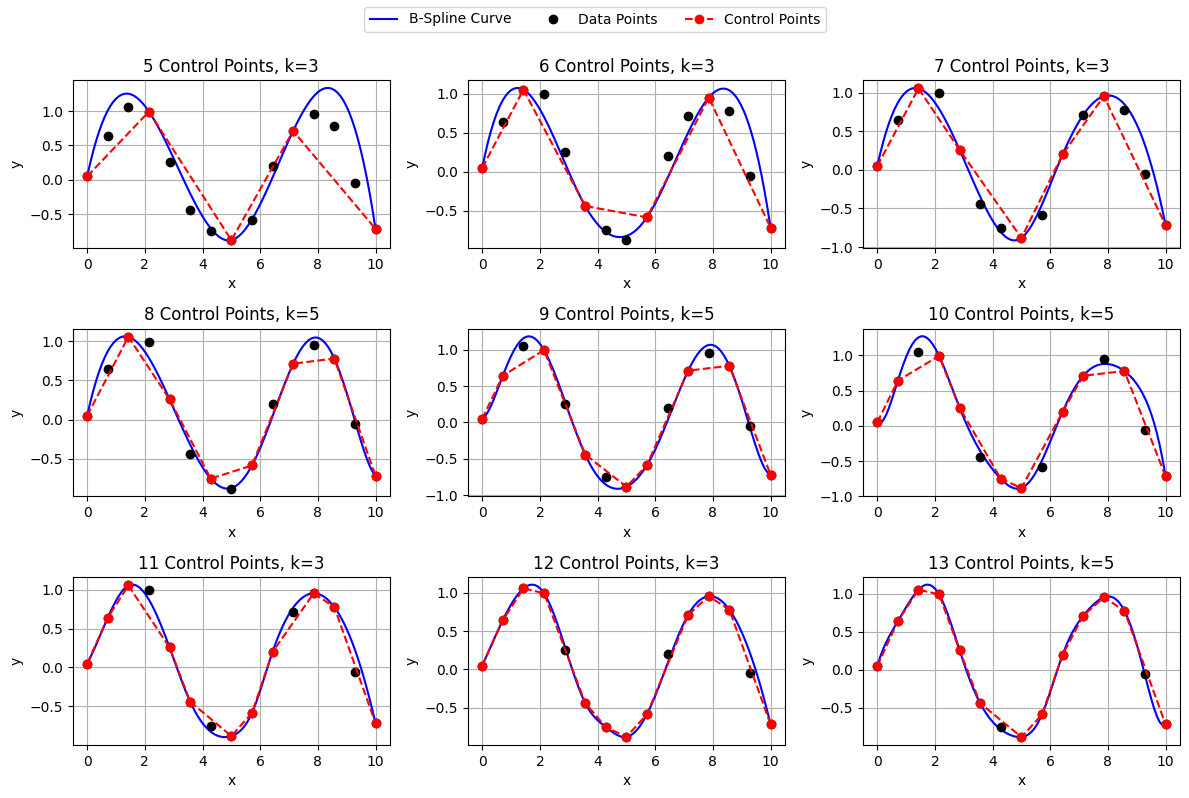

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Generate some data points to be approximated
np.random.seed(42)
x = np.linspace(0, 10, 15)  # Increased number of data points
y = np.sin(x) + 0.1 * np.random.randn(15)

# Define a function to generate B-Spline plots
def plot_bspline_approx(x, y, num_control_points, k, ax):
    # Select control points from the data points
    indices = np.linspace(0, len(x) - 1, num_control_points).astype(int)
    control_points = np.column_stack((x[indices], y[indices]))

    # Ensure no duplicate x-values in control points
    _, unique_indices = np.unique(control_points[:, 0], return_index=True)
    control_points = control_points[np.sort(unique_indices)]

    # Create a B-Spline approximation
    spl = make_interp_spline(control_points[:, 0], control_points[:, 1], k=k)

    # Evaluate the B-Spline at a fine grid of points
    x_spline = np.linspace(x[0], x[-1], 100)
    y_spline = spl(x_spline)

    # Plot the original data points and the B-Spline approximation
    ax.plot(x_spline, y_spline, color='blue')
    ax.plot(x, y, 'o', color='black')
    ax.plot(control_points[:, 0], control_points[:, 1], 'o--', color='red')
    ax.set_title(f'{num_control_points} Control Points, k={k}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)

# Create a figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

# Define different configurations of control points and degrees (using only odd degrees)
configs = [
    (5, 3),
    (6, 3),
    (7, 3),
    (8, 5),
    (9, 5),
    (10, 5),
    (11, 3),
    (12, 3),
    (13, 5)
]

# Plot B-Splines with varying configurations
for i, (num_control_points, k) in enumerate(configs):
    ax = axs[i // 3, i % 3]
    plot_bspline_approx(x, y, num_control_points, k, ax)

# Create a single legend for the entire figure
handles = [
    plt.Line2D([0], [0], color='blue', label='B-Spline Curve'),
    plt.Line2D([0], [0], marker='o', color='black', linestyle='None', label='Data Points'),
    plt.Line2D([0], [0], marker='o', color='red', linestyle='--', label='Control Points')
]

fig.legend(handles=handles, loc='upper center', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In the model hyperparameters, we will basically be adjusting control points (`grid` size) and the degree of the B-Splines (`k`). Also notice how we setup the number of `steps`, `batch_size` and the number of `passes`, so we expose the model to the entire dataset.

```{tip}
Keep in mind $\mathbf{k}$ and `grid` size in this experiment in regards to B-Spline fitting. The combination of these two hyperparameters will determine the model's capacity to fit the data. If the model is too simple, it will underfit the data, and if it is too complex, it will overfit. The goal is to find the right balance between the two to achieve the best performance.
```

In [9]:
import kan as kan

width = [6,2]
grid = 4
update_grid = True
k = 3
symbolic_enabled = False
batch_size = -1 # -1 for full batch
if batch_size == -1:
    steps = 20
else:
    steps = samples // batch_size
passes = 7

model = kan.KAN(width=width,
                grid=grid, k=k,
                device=device,
                symbolic_enabled=symbolic_enabled,
                seed=42)

Let us look at the resulting model's network, you should recognise it from the [previous KAN experiment](../thoughts/kolmogorov-arnold-networks).

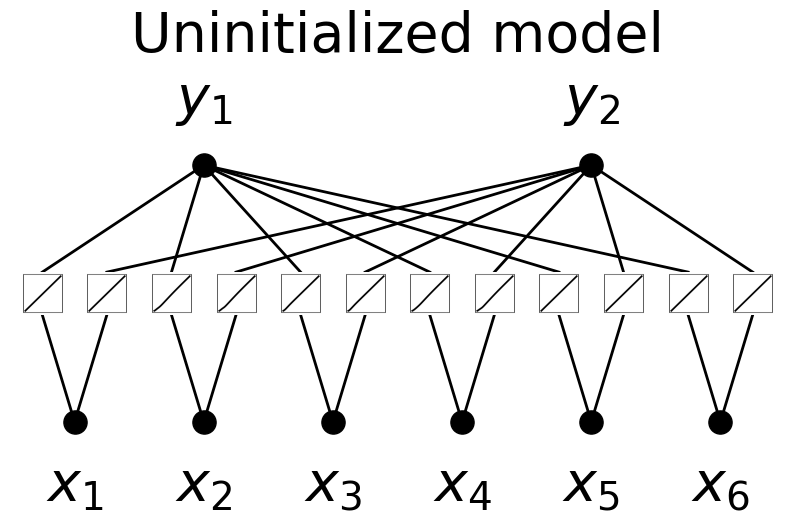

In [10]:
# Plot the uninitialized model

# set in_vars and out_vars as a list of strings such as [r'$x_1$', r'$x_2$', r'$x_n$'] and [r'$y_1$', r'$y_2$', r'$y_n$'] respectively
in_vars = [r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$', r'$x_5$', r'$x_6$']
out_vars = [r'$y_1$', r'$y_2$']

model(X)
model.plot(beta=30,
           scale=1,
           out_vars=out_vars,
           in_vars=in_vars,
           title='Uninitialized model')

## Training the model

We conduct an initial training pass for the model, paying attention to the correlation between `steps` and `passes`. The model will iterate over the entire dataset multiple times, with each pass consisting of several data batches.


In [11]:
import os
import shutil

def train_acc():
    return torch.mean(
        (torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean(
        (torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

images = "../_static/video/.images"
video = "../_static/video"

# Empty images
if os.path.exists(images):
    shutil.rmtree(images)
os.makedirs(images)

results = model.train(dataset,
                        opt="LBFGS",
                        steps=steps*passes,
                        metrics=(train_acc, test_acc),
                        loss_fn=torch.nn.CrossEntropyLoss(),
                        batch=batch_size,
                        update_grid=update_grid,
                        device=device,
                        save_fig=True,
                        img_folder=images)
results['train_acc'][-1], results['test_acc'][-1]

train loss: 7.95e-01 | test loss: 7.96e-01 | reg: 9.47e+00 : 100%|█| 140/140 [02:30<00:00,  1.08s/it


(0.647231936454773, 0.6405520439147949)

In [12]:
# Compile the video of the training process
import os
import numpy as np
import moviepy.video.io.ImageSequenceClip

video_name='predictive-maintenance-kan'
fps=10

fps = fps
files = os.listdir(images)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [images+'/'+str(train_index[index])+'.jpg' for index in train_index]

# Create the video
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video+'/'+video_name+'.mp4', codec="mpeg4")

# Clean up the images
shutil.rmtree(images)

Moviepy - Building video ../_static/video/predictive-maintenance-kan.mp4.
Moviepy - Writing video ../_static/video/predictive-maintenance-kan.mp4



Moviepy - Done !
Moviepy - video ready ../_static/video/predictive-maintenance-kan.mp4


We can track the model's progress during training, thanks to the KAN implementation's feature that allows us to plot and animate the model at each step.

<video width="640" height="480" controls>
  <source src="../_static/video/predictive-maintenance-kan.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

Observe the evolution of both training and test loss throughout the training process. The model exhibits a stepwise learning pattern, indicating periodic adjustments and improvements. By plotting these loss curves, we can gain insights into how well the model is fitting the training data and generalizing to the test data. This visualization helps identify phases of rapid learning, plateaus, and potential overfitting or underfitting issues. Additionally, examining the loss trends can guide further tuning of hyperparameters to enhance model performance.

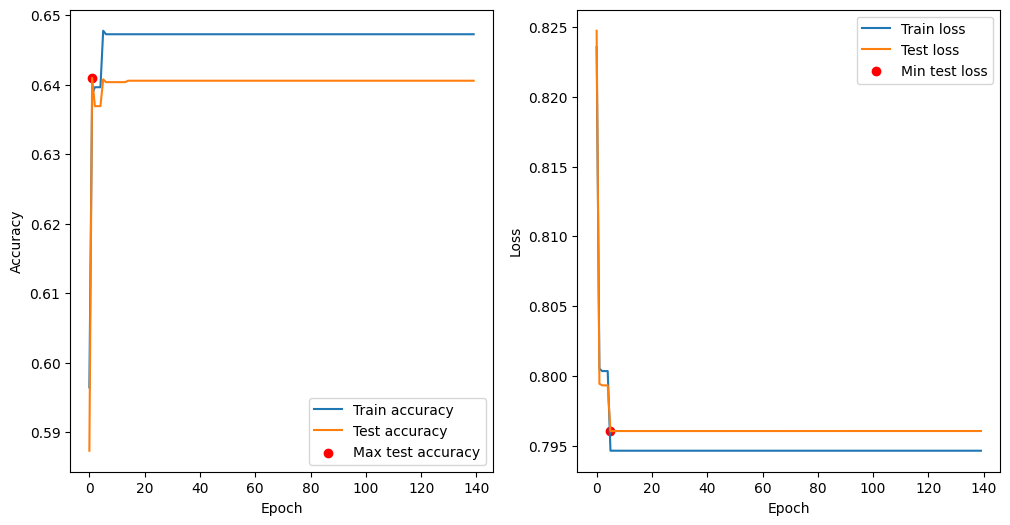

In [13]:
# Plot the training and test accuracy, with markers at the maximum test accuracy and minimum loss
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(results['train_acc'], label='Train accuracy')
ax[0].plot(results['test_acc'], label='Test accuracy')
ax[0].scatter(results['test_acc'].index(max(results['test_acc'])), max(results['test_acc']), color='red', label='Max test accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(results['train_loss'], label='Train loss')
ax[1].plot(results['test_loss'], label='Test loss')
ax[1].scatter(results['test_loss'].index(min(results['test_loss'])), min(results['test_loss']), color='red', label='Min test loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

## Training the model further

You may have noticed that the model's performance "plateaus" after a certain point in the training process. This stagnation is likely due to an insufficient number of control points in the B-Splines used for the activation functions. To address this, we will incrementally increase the number of control points in a loop, allowing the model to better capture the underlying patterns in the data. We will maintain a constant degree for the B-Splines (\(\mathbf{k}\)) during this process. By enhancing the flexibility of the activation functions, we aim to improve the model's capacity to learn and generalize, thereby overcoming the plateau and achieving better performance.

In [14]:
# Loss plateaus after a while, let's continue with a more fine grained network

# We will iterate over a range of grid sizes and degrees to find the best model,
# starting from the previous best model, and slightly increasing the grid size each time.

iterations = 10
grid_factor = 1.7
grid_max = 500

grids = np.array([int(grid*grid_factor)])
for i in range(iterations):
    prev_index = max(0, i-1)
    # Calculate the next grid size as 1.15 times the previous grid size, up to a maximum of 12
    grids = np.append(grids, min(int(grids[prev_index]*grid_factor), grid_max))

# Drop duplicates
grids = np.unique(grids)

train_accs = []
test_accs = []
train_losses = []
test_losses = []

max_acc = results['test_acc'][-1]
best_model = model

print("Grids: ", grids)

for i in range(iterations):
    model = kan.KAN(width=width,
                        grid=grids[i],
                        k=k,
                        device=device,
                        symbolic_enabled=symbolic_enabled,
                        seed=42).initialize_from_another_model(best_model, dataset['train_input'])

    results = model.train(dataset,
                            opt="LBFGS",
                            steps=steps*passes,
                            metrics=(train_acc, test_acc),
                            loss_fn=torch.nn.CrossEntropyLoss(),
                            batch=batch_size,
                            update_grid=update_grid,
                            device=device)
    train_accs += results['train_acc']
    test_accs += results['test_acc']
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    # Update max_acc
    if results['test_acc'][-1] > max_acc:
        max_acc = results['test_acc'][-1]
        best_model = model
        print(f"New max accuracy: {max_acc} for grid size {grids[i]}")
    print("train accuracy: ", results['train_acc'][-1], " test accuracy: ", results['test_acc'][-1], " max accuracy: ", max_acc)

Grids:  [ 6 10 17 28 47 79]


train loss: 7.88e-01 | test loss: 7.89e-01 | reg: 9.39e+00 : 100%|█| 140/140 [00:10<00:00, 13.29it/s


New max accuracy: {max_acc} for grid size {grids[i]}
train accuracy:  0.654691219329834  test accuracy:  0.658818781375885  max accuracy:  0.658818781375885


train loss: 7.88e-01 | test loss: 7.89e-01 | reg: 9.39e+00 : 100%|█| 140/140 [00:08<00:00, 15.94it/s


New max accuracy: {max_acc} for grid size {grids[i]}
train accuracy:  0.654691219329834  test accuracy:  0.6600365042686462  max accuracy:  0.6600365042686462


train loss: 7.87e-01 | test loss: 7.88e-01 | reg: 9.40e+00 :   6%|  | 8/140 [00:03<00:58,  2.26it/s]


KeyboardInterrupt: 

Did that help ? Let us plot the training and test loss evolution for the model with more control points.

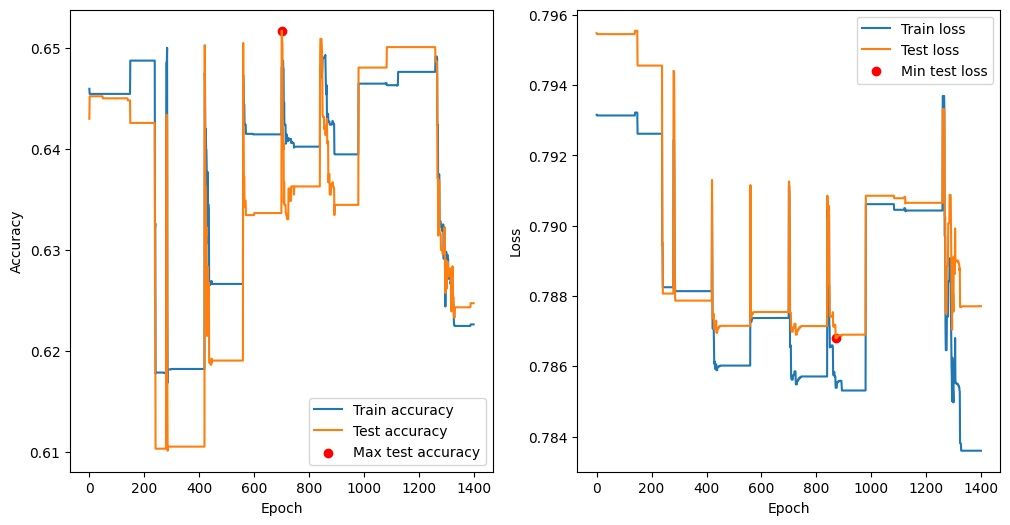

In [ ]:
# Plot the training and test accuracy, with markers at the maximum test accuracy and minimum loss
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(train_accs, label='Train accuracy')
ax[0].plot(test_accs, label='Test accuracy')
ax[0].scatter(test_accs.index(max(test_accs)), max(test_accs), color='red', label='Max test accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(train_losses, label='Train loss')
ax[1].plot(test_losses, label='Test loss')
ax[1].scatter(test_losses.index(min(test_losses)), min(test_losses), color='red', label='Min test loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()


Indeed, increasing the number of control points resulted in a slight improvement in both training and test losses as well as accuracy. The training loss and accuracy curves indicate that the model has become better at fitting the training data, while the test loss and accuracy suggest a marginal improvement in the model's ability to generalize to unseen data.

However, it is important to note that this dataset is inherently very complex. Despite the enhancements, the model still faces challenges in achieving significant performance gains. The fluctuations in the loss and accuracy curves highlight the ongoing struggle to find a balance between underfitting and overfitting, a common issue when dealing with such intricate data. Further tuning and potentially more sophisticated techniques may be required to see more substantial improvements.

Let us look at the final model's network.

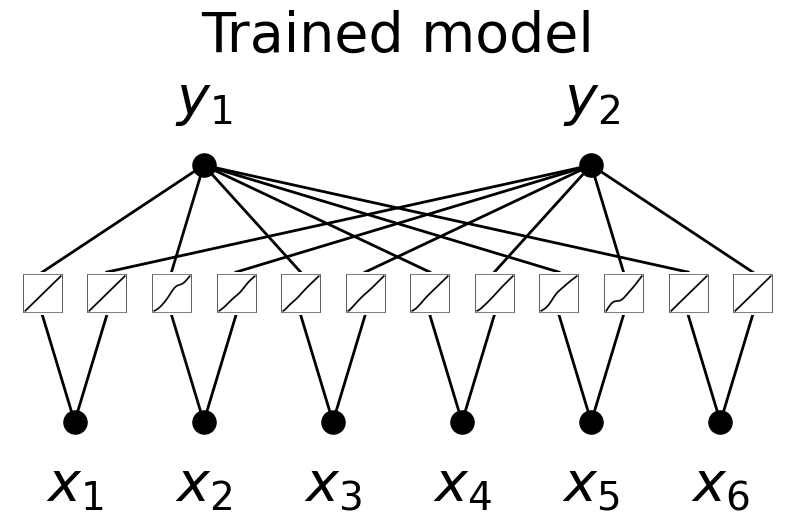

In [ ]:
best_model(X)
best_model.plot(beta=30,
                scale = 1.0,
                out_vars=out_vars,
                in_vars=in_vars,
                title='Trained model')

## Evaluating predictions

Finally, we assess the model’s predictions using the test set.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

def get_predictions_and_labels(model, inputs, labels):
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    return predicted.numpy(), labels.numpy()

# Get predictions and actual labels
predicted_labels, true_labels = get_predictions_and_labels(best_model, dataset['test_input'], dataset['test_label'])

# Print a classification report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.67      0.49      0.57      2464
           1       0.60      0.76      0.67      2463

    accuracy                           0.62      4927
   macro avg       0.63      0.62      0.62      4927
weighted avg       0.63      0.62      0.62      4927



 Notably, the model performs equally well for both classes, indicating an absence of bias and suggesting balanced learning. As a final step, let us see the confusion matrix for the model's predictions.

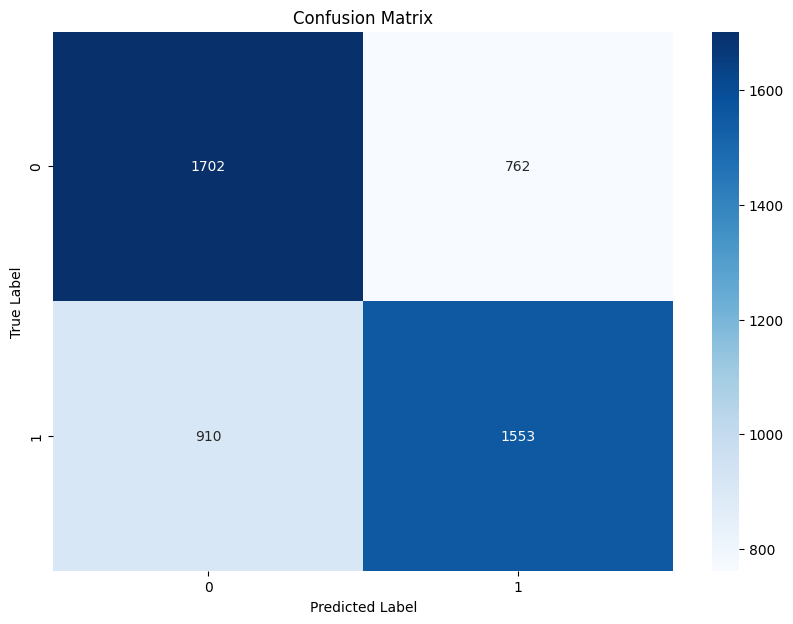

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Final remarks

The Kolmogorov-Arnold Network presents a novel and promising approach to predictive maintenance, leveraging the power of B-Splines to model complex relationships within the data. Through this experiment, we demonstrated the model's capability to learn from a challenging dataset and achieve balanced performance across classes. While the KAN model is not without its challenges, including computational complexity and the need for extensive hyperparameter tuning, it offers significant potential.

Comparing the KAN model's performance with baseline models such as Random Forests, Support Vector Machines, and simple Neural Networks can provide valuable insights. Metrics such as accuracy, precision, recall, F1-score, and computational efficiency should be used for comprehensive evaluation.

### Performance Comparison: Kolmogorov-Arnold Network vs. Random Forests

To evaluate the effectiveness of the Kolmogorov-Arnold Network (KAN) and Random Forests (RF) in the context of predictive maintenance, we compare their performance metrics on the same dataset. Here are the key performance indicators for both models:

#### Kolmogorov-Arnold Network (KAN) Performance

The KAN model has a precision of 0.65 for both Class 0 and Class 1, resulting in a weighted average precision of 0.65. The recall for both classes is also 0.65, leading to a weighted average recall of 0.65. Similarly, the F1-score is 0.65 for both classes and the weighted average. The overall accuracy of the KAN model is 0.65.

#### Random Forest (RF) Performance

The Random Forest model achieves a precision of 0.69 for Class 0 and 0.72 for Class 1, resulting in a weighted average precision of 0.70. The recall for Class 0 is 0.74 and for Class 1 is 0.66, leading to a weighted average recall of 0.70. The F1-score is 0.71 for Class 0 and 0.69 for Class 1, with a weighted average of 0.70. The overall accuracy of the Random Forest model is 0.70.

### Comparative Analysis

In terms of accuracy, the Random Forest model achieves 70%, outperforming the KAN model, which has an accuracy of 65%. For precision, the Random Forest model has a precision of 0.69 for Class 0, compared to KAN’s 0.65, and for Class 1, Random Forest outperforms KAN with a precision of 0.72 versus 0.65. The overall weighted precision for Random Forest is higher at 0.70, compared to 0.65 for KAN.

The recall for Class 0 is higher in Random Forest (0.74) compared to KAN (0.65). For Class 1, KAN has a recall of 0.65, while Random Forest has a slightly lower recall of 0.66. The overall weighted recall for Random Forest is again higher at 0.70, compared to 0.65 for KAN.

The F1-score for Class 0 is 0.71 in Random Forest, whereas it is 0.65 in KAN. For Class 1, the F1-score for Random Forest is 0.69, compared to 0.65 for KAN. The overall weighted F1-score for Random Forest is 0.70, outperforming KAN’s 0.65.

### Interpretation

Overall, the Random Forest model consistently outperforms the Kolmogorov-Arnold Network across all major metrics: precision, recall, F1-score, and accuracy. This suggests that Random Forests are more effective at classifying engine conditions correctly in this dataset. 

The KAN model shows uniform performance across both classes with precision, recall, and F1-scores all at 0.65. This indicates balanced learning but at a lower overall performance level. Random Forest, however, shows a slight bias towards Class 0, with higher precision and recall. Despite this, it maintains superior overall performance.

The KAN model, while innovative and capable of capturing complex non-linear relationships through B-Splines, may require more fine-tuning and computational resources. Random Forest, being an ensemble method, provides robustness and ease of interpretation with better performance, making it a more practical choice for this specific predictive maintenance application.